In [1]:
import pandas as pd
import sklearn
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer, PowerTransformer, StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#load the data from the csv to the pandas df


In [21]:
def data_transformer(df, file):
    columns_to_drop = ["imdb_id", "original_title", "poster_path", "status", "title"]
    df.drop(columns=columns_to_drop, inplace=True)
    df["belongs_to_collection"] = np.where(df["belongs_to_collection"].isnull(), 0, 1)
    df["homepage"] = np.where(df["homepage"].isnull(), 0, 1)
    df["original_language"] = np.where(df["original_language"]=="en", 1, 0)
    df['release_date'] = pd.to_datetime(df['release_date'], format='%m/%d/%y')
    df['release_date'] = df['release_date'].apply(lambda x: x.replace(year=x.year-100) if x.year > 2019 else x)
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['overview'] = df['overview'].astype(str).apply(len)
    df['tagline'] = df['tagline'].astype(str).apply(len)
    colList = ["genres"]
    for col in colList:
        df[col] = np.where(df[col].isnull(), "[]", df[col])
        df[col] = df[col].apply(ast.literal_eval)
        df[col] = df[col].apply(lambda x: [str(item["id"]) for item in x])
        mlb = MultiLabelBinarizer()
        newData = mlb.fit_transform(df[col])
        newDf = pd.DataFrame(newData, columns=col+"_" + mlb.classes_)
        df = pd.merge(df, newDf, how='inner', left_index=True, right_index=True)
        df[col] = df[col].apply(len)
        df = df.rename(columns={col: col+"_num"})
    if 'genres_10770' not in df.columns:
        df['genres_10770'] = 0

    colList = ["production_companies", "spoken_languages", "Keywords", "cast", "crew", "production_countries"]

    for col in colList:
        df[col] = np.where(df[col].isnull(), "[]", df[col])
        df[col] = df[col].apply(ast.literal_eval)
        df[col] = df[col].apply(len)
        df = df.rename(columns={col: col+"_num"})
    excel_file_path = 'clean_'+file+'.xlsx'
    df.to_excel(excel_file_path, index=False)
    return df

In [22]:
df = pd.read_csv('train.csv')
training = data_transformer(df, "train")

df = pd.read_csv('test.csv')
testing = data_transformer(df, "test")


In [2]:
training = pd.read_excel('clean_train.xlsx')
testing = pd.read_excel('clean_test.xlsx')

In [19]:
training

,id,belongs_to_collection,budget,genres_num,homepage,original_language,overview,popularity,production_companies_num,production_countries_num,...,genres_27,genres_28,genres_35,genres_36,genres_37,genres_53,genres_80,genres_878,genres_9648,genres_99
0,1,1,14000000,1,0,1,155,6.575393,3,1,...,0,0,1,0,0,0,0,0,0,0
1,2,1,40000000,4,0,1,393,8.248895,1,1,...,0,0,1,0,0,0,0,0,0,0
2,3,0,3300000,1,1,1,130,64.299990,3,1,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1200000,2,1,0,581,3.174936,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,0,0,2,0,0,168,1.148070,0,1,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,0,0,2,0,1,261,9.853270,2,1,...,0,0,1,0,0,0,0,0,0,0
2996,2997,0,0,2,0,0,141,3.727996,2,2,...,0,0,0,0,0,0,0,0,0,0
2997,2998,0,65000000,4,0,1,318,14.482345,3,1,...,0,1,0,0,0,1,1,0,1,0
2998,2999,0,42000000,2,1,1,341,15.725542,2,1,...,0,0,1,0,0,0,0,0,0,0


In [25]:
training['crew_num']

0       72
1        9
2       64
3        3
4        2
        ..
2995    17
2996    15
2997    10
2998    89
2999    48
Name: crew_num, Length: 3000, dtype: int64

In [26]:
logTransformList = ['budget', 'popularity', 'runtime', 'crew_num', 'cast_num', 'overview', 'tagline']

for col in logTransformList:
    training[col] = np.log1p(training[col])

columns_to_standardize = ['budget', 'genres_num','popularity', 'production_companies_num','production_countries_num', 'runtime',
       'spoken_languages_num', 'Keywords_num', 'cast_num', 'crew_num','overview', 'tagline']
xScaler = StandardScaler()


standardized = xScaler.fit_transform(training[columns_to_standardize])

# Concatenate the standardized columns with the original columns
X_train = np.concatenate((standardized, training[['belongs_to_collection',  'homepage',
       'original_language', 
        'genres_10402', 'genres_10749', 'genres_10751',
       'genres_10752', 'genres_10769', 'genres_10770', 'genres_12',
       'genres_14', 'genres_16', 'genres_18', 'genres_27', 'genres_28',
       'genres_35', 'genres_36', 'genres_37', 'genres_53', 'genres_80',
       'genres_878', 'genres_9648', 'genres_99']]), axis=1)

training['revenue'] = np.log1p(training['revenue'])
y_train = training['revenue']
y_train = y_train.values.reshape(-1, 1)

yScaler = StandardScaler()
y_train = yScaler.fit_transform(y_train)
y_train = y_train.ravel()

In [27]:
for col in logTransformList:
    testing[col] = np.log1p(testing[col])
standardized = xScaler.transform(testing[columns_to_standardize])

# Concatenate the standardized columns with the original columns
X_test = np.concatenate((standardized, testing[['belongs_to_collection',  'homepage',
       'original_language', 
        'genres_10402', 'genres_10749', 'genres_10751',
       'genres_10752', 'genres_10769', 'genres_10770', 'genres_12',
       'genres_14', 'genres_16', 'genres_18', 'genres_27', 'genres_28',
       'genres_35', 'genres_36', 'genres_37', 'genres_53', 'genres_80',
       'genres_878', 'genres_9648', 'genres_99']]), axis=1)

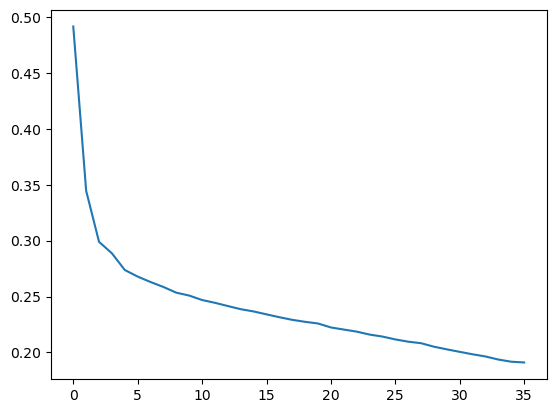

In [59]:
model = MLPRegressor(hidden_layer_sizes=(128, 64), batch_size=512, learning_rate_init=0.001, max_iter=1000, learning_rate="invscaling", early_stopping=True, n_iter_no_change=10, solver="adam")
model.fit(X_train, y_train)
plt.plot(model.loss_curve_)
y_test = model.predict(X_test)
yResult = np.expm1(yScaler.inverse_transform(y_test.reshape(-1, 1)).flatten())
submitResult = pd.DataFrame({'id': testing['id'], 'revenue': yResult})
submitResult.to_csv('submit.csv', index=False)

In [34]:
yResult

array([ 4618416.88114276,  1134719.50654468,  4510261.64916962, ...,
       52327264.25378964, 22814631.05450093,  2465283.88779954])

In [58]:
submitResult = pd.DataFrame({'id': testing['id'], 'revenue': yResult})
submitResult.to_csv('submit.csv', index=False)